In [1]:
#Mount Drive if running in Colab
from sys import path
import os

if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  root_PATH = '/content/drive/My Drive/nlp-seminar/repository'
  drive_mount_location = '/content/drive'

  drive.mount(drive_mount_location, force_remount=True)
  path.append(root_PATH)
else:
  root_PATH = os.path.abspath("../..")

%load_ext autoreload
%autoreload 2

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [18]:
import pandas as pd
from data_cleaner import DataCleaner
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [3]:
#Load datasets
train_df = pd.read_csv(root_PATH + '/data/train.csv')
validation_df = pd.read_csv(root_PATH + '/data/validation.csv')

In [4]:
#Clean datasets for naive Bayes method
train_df['Conversation'] = train_df['Conversation'].map(lambda row : DataCleaner.clean_text_naive_bayes(str(row)))
validation_df['Conversation'] = validation_df['Conversation'].map(lambda row : DataCleaner.clean_text_naive_bayes(str(row)))

In [5]:
#Obtain a list with all the topics in the dataset
train_df["Topic"] = train_df["Topic"].apply(eval)
validation_df["Topic"] = validation_df["Topic"].apply(eval)

def list_to_series(series):
    return pd.Series([x for _list in series for x in _list])

In [7]:
#Add a boolean mask to the dataset
def boolean_df(item_lists, unique_items):# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

train_topics = list_to_series(train_df["Topic"]).value_counts().index.tolist()
train_boolean_mask = boolean_df(train_df["Topic"],train_topics).astype(int)

validation_topics = list_to_series(validation_df["Topic"]).value_counts().index.tolist()
validation_boolean_mask = boolean_df(validation_df["Topic"],train_topics).astype(int)

In [8]:
#Train and evaluate a Naive Bayes classifier (without stemming)

x_train = train_df["Conversation"]
x_test = validation_df["Conversation"]
stop_words = set(stopwords.words('english'))

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for topic in validation_topics:
    print('... Processing {}'.format(topic))
    # train the model using X_dtm & y
    NB_pipeline.fit(x_train, train_boolean_mask[topic])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(x_test)
    
    print('Test accuracy is {}'.format(accuracy_score(validation_boolean_mask[topic], prediction)))

... Processing Satisfied users
Test accuracy is 0.8402909349846776
... Processing Bugs
Test accuracy is 0.9192744427348906
... Processing Design & UX
Test accuracy is 0.9252190277583511
... Processing Dissatisfied users
Test accuracy is 0.9310555294177486
... Processing Performance
Test accuracy is 0.951578652899813
... Processing Use cases
Test accuracy is 0.951998270666175
... Processing Gaming
Test accuracy is 0.957135409381636
... Processing Feature Requests
Test accuracy is 0.9591126991594929
... Processing Complexity
Test accuracy is 0.9695713540938163
... Processing Pricing
Test accuracy is 0.9737039533079868
... Processing Security & Accounts
Test accuracy is 0.9734496395101916
... Processing Update
Test accuracy is 0.9729410119146015
... Processing Camera & Photos
Test accuracy is 0.9750581742812456
... Processing Video
Test accuracy is 0.9756049489465051
... Processing Customer Support
Test accuracy is 0.9751344684205842
... Processing Notifications & Alerts
Test accuracy is 

In [9]:
train_df_complete = train_df.join(train_boolean_mask)
validation_df_complete = validation_df.join(validation_boolean_mask)

In [12]:
#Analysis of the categories with a very high accuracy
#comments_with_topic = train_df_complete.loc[train_df_complete['Touch ID'] == 1]

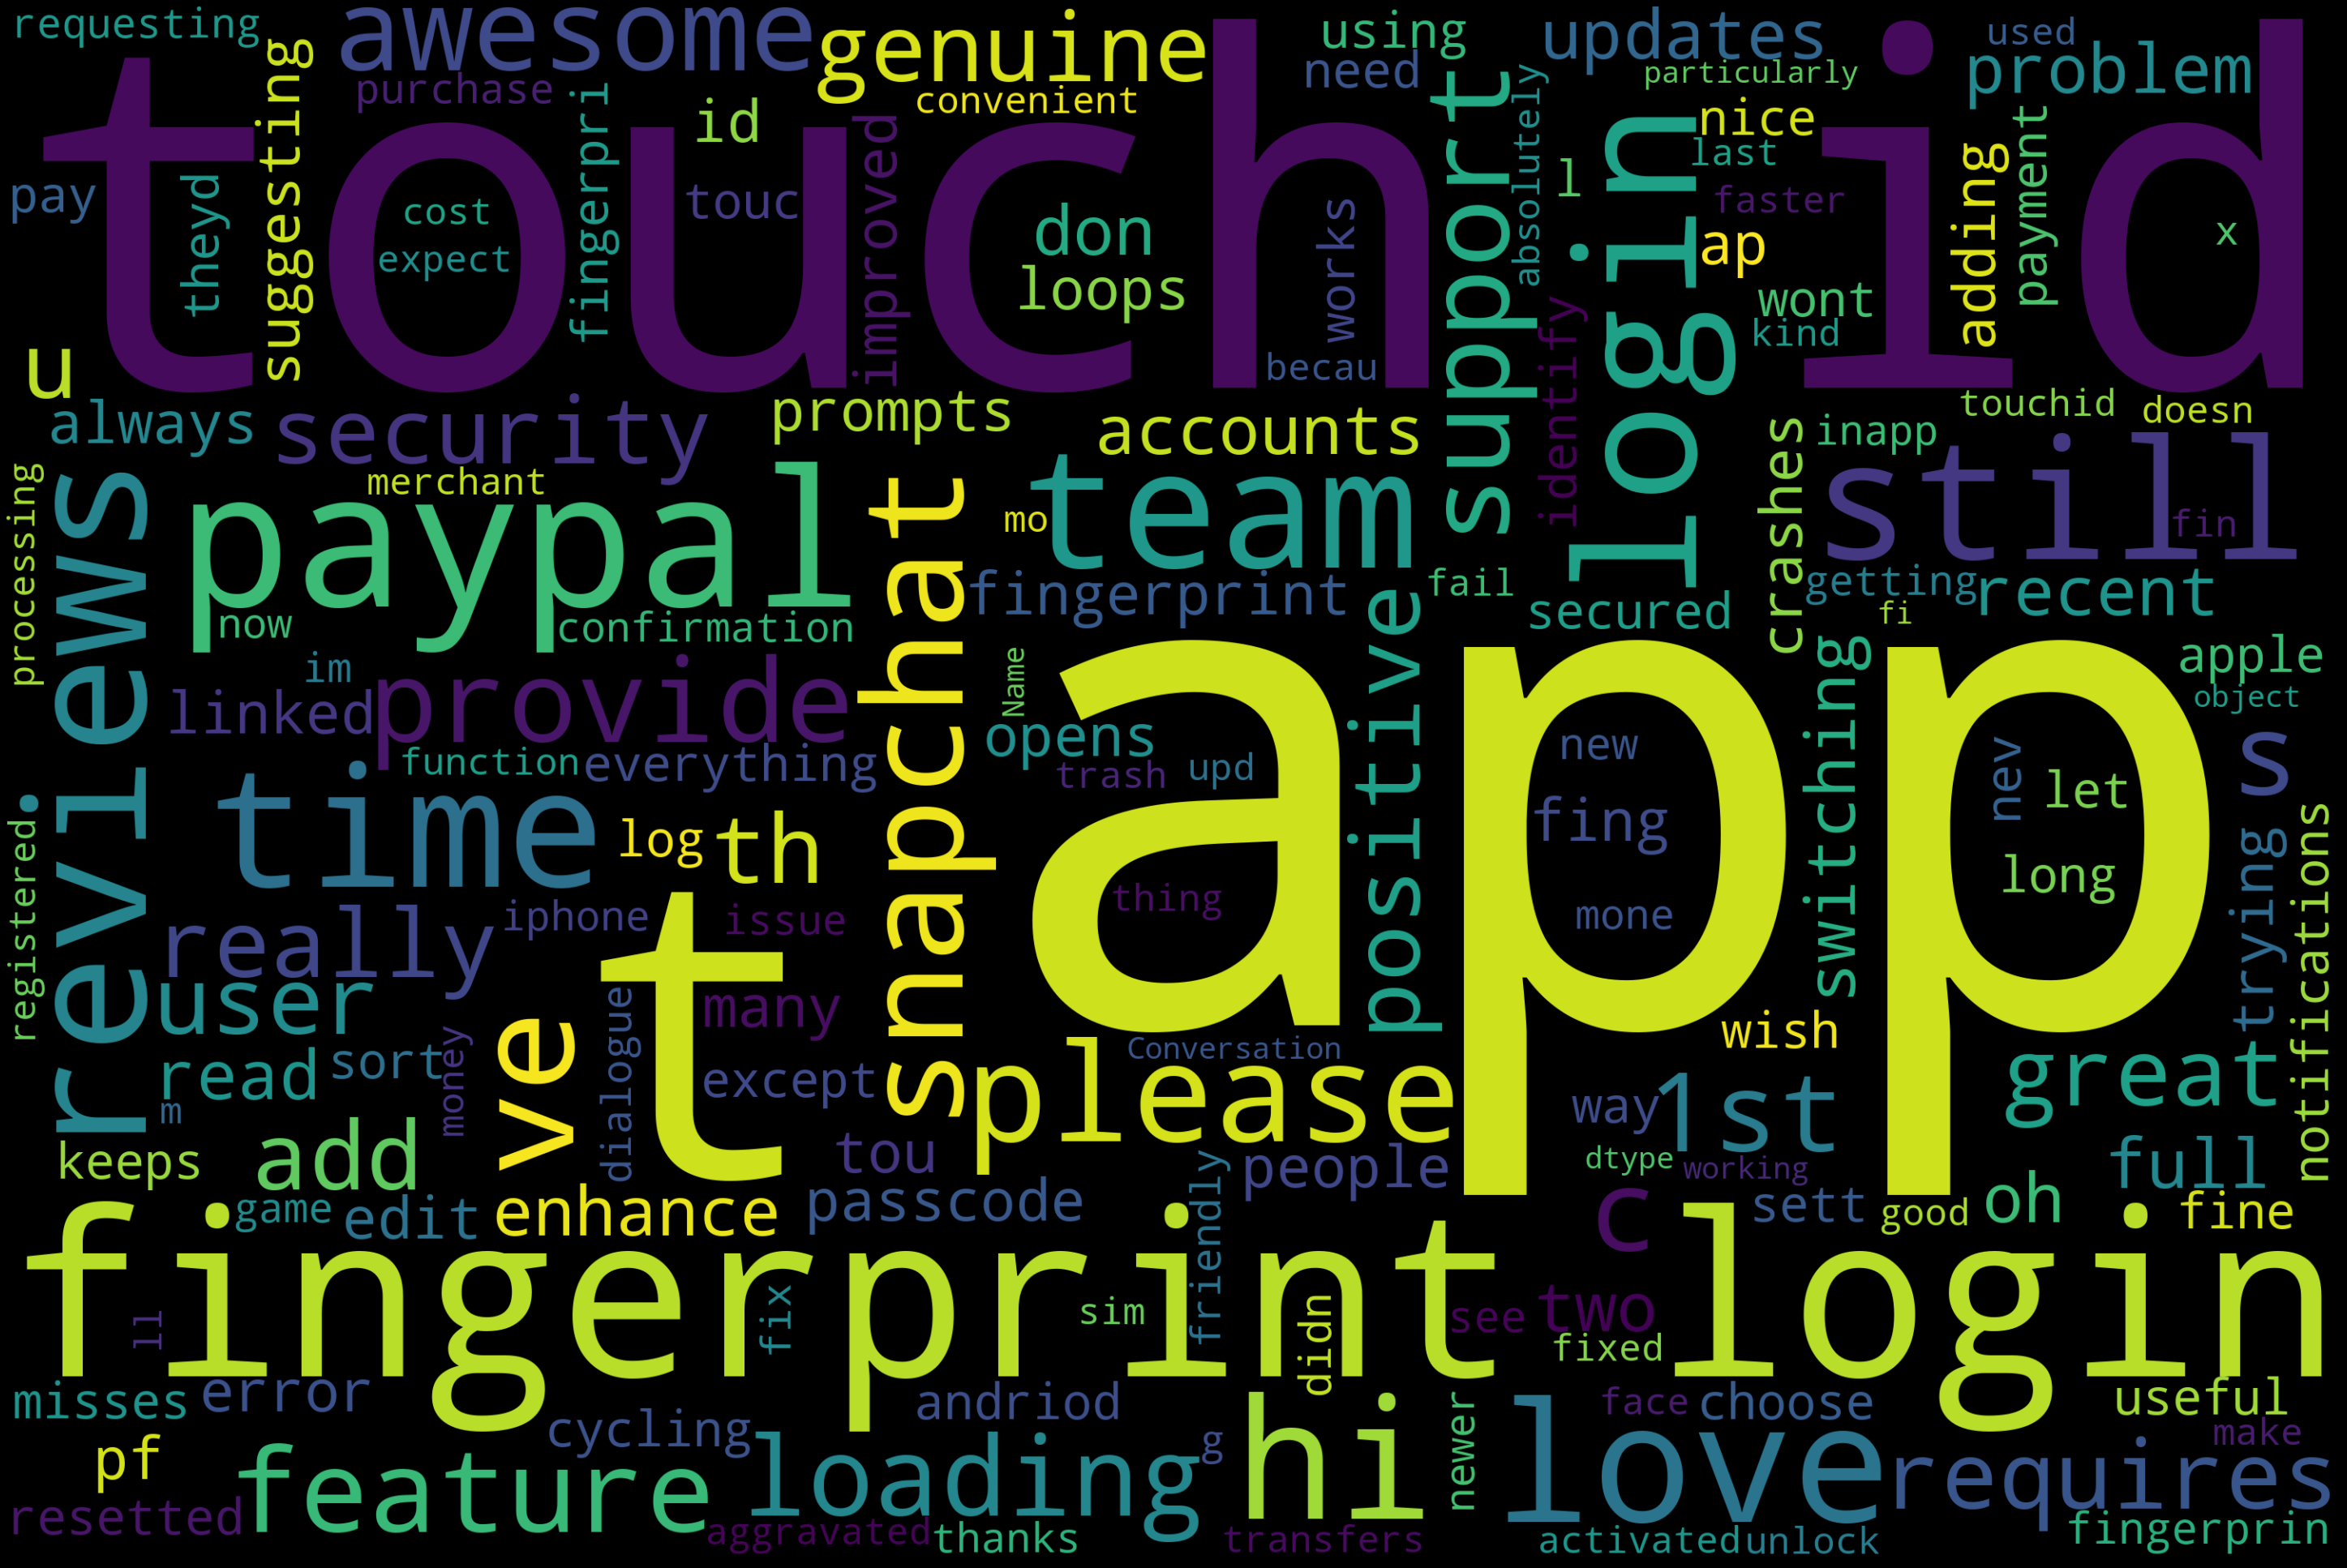

In [26]:
#Wordcloud of the category Touch ID (one of the underrepresented categories, which achieved a great accuracy with a simple Naive Bayes baseline)
topic = "Touch ID"
data_containing_topic = train_df_complete.loc[train_df_complete[topic] == 1]

text = data_containing_topic.Conversation
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [36]:
#All messages related with touch ID have the words "touch id, fingerprint","touchid"?
data_containing_topic

data_with_word = data_containing_topic[data_containing_topic['Conversation'].str.contains("touch id") | data_containing_topic['Conversation'].str.contains("fingerprint") | data_containing_topic['Conversation'].str.contains("touchid")]

data_without_word = data_containing_topic[~data_containing_topic['Conversation'].str.contains("touch id") & ~data_containing_topic['Conversation'].str.contains("fingerprint")]

#Yes, 100% of the messages containing the words "touch id, fingerprint","touchid" have the topic touchid

In [ ]:
#TODO: Analyze results for other categories that are not so precise (do they also have key words?)